Import the necessary packages

In [190]:
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
# Display all floats rounded off to 1 decimal place
pd.options.display.float_format = '{:,.1f}'.format
# Plot inline in Jupyter notebook
%matplotlib inline
# Settings throughout the notebook
sns.set()
# Width = 16, Height = 6
DIMS=(16, 6)

Define the optimization test function here - Bukin Function N.6

https://www.sfu.ca/~ssurjano/bukin6.html

/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


Text(0, 0.5, 'x2')

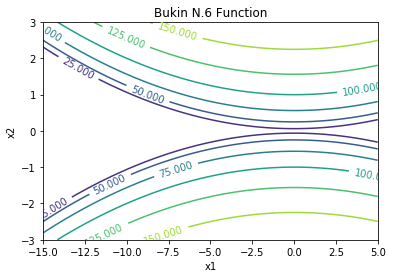

In [103]:
i1 = np.arange(-15.0, 5.0, 0.01)
i2 = np.arange(-3.0, 3.0, 0.01)
x1m, x2m = np.meshgrid(i1, i2)
fm = np.zeros(x1m.shape)
for i in range(x1m.shape[0]):
    for j in range(x1m.shape[1]):
        fm[i][j] = 100 * np.sqrt(abs(x2m[i][j]) - 0.01*(x1m[i][j]**2)) + 0.01 * abs(x1m[i][j] + 10)
plt.figure()
        # Specify contour lines
        #lines = range(2,52,2)
        # Plot contours
CS = plt.contour(x1m, x2m, fm)#,lines)
        # Label contours
plt.clabel(CS, inline=1, fontsize=10)
        # Add some text to the plot
plt.title('Bukin N.6 Function')
plt.xlabel('x1')
plt.ylabel('x2')
# plt.plot(x[:,0],x[:,1],'y-o')
# plt.savefig('contour.png')

In order to apply the simulated annealing method to a specific problem, one must specify the following parameters: the boundary, the energy (goal) function E(), the candidate generator procedure neighbour(), the acceptance probability function P(), and the annealing schedule temperature() AND initial temperature <init temp>. 

In [86]:
# note if you want to change the function, remember to change the boundaries at which the function is evaluated!
i1 = np.arange(-15.0, 10., 0.01)
i2 = np.arange(-10.0, 10.02, 0.01)

class Annealer(object):
    
    '''
    Pass the max steps you want to take to the annealer function
    '''
    
    def __init__(self, maxsteps=1000, multiplier=1, control_t = 1):
        '''
        inputs: total number of steps to try, geometric multiplier for annealing schedule
        
        Initialize parameters
        
        output: none
        '''
        self.Tmax = maxsteps
        self.threshold = multiplier
        self.p = 1
        self.interval = list()
        self.over_count = 0
        self.states = {"x":list(), "y":list()}
        self.control = control_t
        
    def random_start(self):
        """ 
        input: none
        
        Randomly choose a point within the boundary
        
        output: (x1, x2)
        """
        self.interval = [np.random.uniform(low=i1[0], high=i1[-1], size=1)[0], np.random.randint(low=i2[0], high=i2[-1], size=1)[0]]
        self.states["x"].append(self.interval[0])
        self.states["y"].append(self.interval[1])
        
        return self.interval
    
    def boundary(self, x, cat):
        """ 
        input: x + delta x
        
        Check whether a given x (x1 or x2) is within the boundary interval
        
        output: true / false
        """
        result = False
        if cat == "x":
            a, b = i1[0], i1[-1]
        else:
            a, b = i2[0], i2[-1]
        if max(min(x, b), a) == x:
            result = True
        return result
    
    def f(self, x):
        '''
        input: x (a 2D array)
        
        Function that evaluates the cost of a given x1, x2
        
        output: single cost
        '''
        x1 = x[0]
        x2 = x[1]
        
        'levy function n.13 - multimodal function'
        #obj = (np.sin(3*np.pi*x[0])**2) + (((x[0]-1)**2) * (1+(np.sin(3*np.pi*x[1]))**2)) + (((x[1]-1)**2) * (1+(np.sin(2*np.pi*x[1]))**2))
        
        'bukin function n.6 - many local minima'
        obj = 100 * np.sqrt(abs(x[1] - 0.01*(-x[0])**2)) + 0.01 * abs(x[0] + 10)
        
        'griewank function - many local minima'
        #obj = ((x[0]**2+x[1]**2) / 4000) - (np.cos(x[0])*np.cos(x[1])) + 1
        
        'eggholder function - many local minima'
        #obj = (-(x[1]+47)*np.sin(np.sqrt(abs(x[1] + (x[0]/2) + 47)))) - (x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]+47)))))
        
        return obj

    def random_neighbour(self, x):
        """ 
        input: x (a 2D array)
        
        Move a little bit x1 and x2, from the left or the right and then check whether it's within
        the boundary. (normalized by the min and max) 
        if it's within the boundary, return the new coordinates, otherwise find new ones.
        
        output: (newx, newy)
        """
        
        # normalized 
        deltax = np.random.uniform(low=i1[0], high=i1[-1], size=1) / (i1[-1]-i1[0])
        deltay = np.random.uniform(low=i2[0], high=i2[-1], size=1) / (i2[-1]-i2[0]) 
        
        newx = x[0] + deltax
        newy = x[1] + deltay

        while ((self.boundary(newx,'x')==False) or (self.boundary(newy, 'y')==False)):
            deltax = np.random.uniform(low=i1[0], high=i1[-1], size=1) / (i1[-1]-i1[0])
            deltay = np.random.uniform(low=i2[0], high=i2[-1], size=1) / (i2[-1]-i2[0]) 
            newx = x[0] + deltax
            newy = x[1] + deltay
            self.over_count += 1
            
        return [newx, newy]
    
    def acceptance_probability(self, cost, new_cost, temperature):
        '''
        inputs: old cost, new cost, current temperature
        
        calculate probability of acceptance and return it
        
        output: probability (0 to 1)
        '''
        self.p = np.exp((-(new_cost - cost)) / temperature)
        return self.p 
    
    def anneal(self, debug=True):
        '''
        inputs: none
        
        function performs annealing and calls random start to kickstart the annealing process. iteratively
        calculates the new cost.
        
        output: final cost, final state (list of x1 and x2), all costs (list of costs at every timestep)
        '''
        state = self.random_start()
        cost = self.f(state)
        states, costs = state, [cost]
        for step in range(self.Tmax):
            fraction = step / float(self.Tmax)
            T = max(fraction*(1-self.control), (1 - fraction)*self.control) * self.threshold
            new_state = self.random_neighbour(state)
            self.states["x"].append(new_state[0])
            self.states["y"].append(new_state[1])
            new_cost = self.f(new_state)
            #if debug: print("Step #{:>2}/{:>2} : T = {:>4.3g}, state = {}, cost = {:>4.3g}, new_state = {}, new_cost = {:>4.3g} ...".format(step, self.maxsteps, T, state, cost, new_state, new_cost))
            if self.acceptance_probability(cost, new_cost, T) >= np.random.uniform(0,1):
                if np.sqrt(np.sum(np.subtract(new_cost, cost)**2)) >= np.random.uniform(0,1):
                    state, cost = new_state, new_cost
                    states.append(state)
                    costs.append(cost)
        
        return self.f(state), states, costs


Test with 10000 steps

In [49]:
final_state, states, costs = Annealer(10000).anneal()
print(final_state)
print(final_cost)
print(states)
print(costs)

[array([-242.7748016]), array([274.31781282])]
[-559.78258665]
[-249.94132479981414, 333, [array([-249.97083742]), array([332.65793172])], [array([-249.69135692]), array([332.28964923])], [array([-249.92230824]), array([332.10885328])], [array([-249.61113214]), array([331.93363267])], [array([-250.08914447]), array([331.6698698])], [array([-250.57350274]), array([331.17992072])], [array([-250.85898809]), array([331.35812613])], [array([-251.27953053]), array([330.99381041])], [array([-250.87540304]), array([330.56184288])], [array([-250.8792612]), array([330.07504646])], [array([-250.94399219]), array([330.03542593])], [array([-250.62876976]), array([329.69103231])], [array([-250.39161064]), array([329.20017089])], [array([-249.91877982]), array([329.00477121])], [array([-249.67640559]), array([328.80147392])], [array([-250.07119038]), array([328.43606099])], [array([-250.35149452]), array([328.32844895])], [array([-250.57062406]), array([327.92113717])], [array([-250.95533066]), array

# For Case (1-ti/Tmax)

In [87]:
df_case1 = pd.DataFrame(columns=['iterations','init_x','init_y','final_x','final_y','cost'])

cost_1 = dict()

for i in range(0,100001,10000):
    if i != 0:
        a = Annealer(i, 1, 1)
        obj, states, costs = a.anneal()
        #average.append(np.average(costs))
        print([i,j/10,a.states["x"][0],a.states["y"][0], states[-1][0][0], states[-1][1][0], float(costs[-1])])
        df_case1 = df_case1.append({"iterations":i,"init_x":a.states["x"][0], "init_y":a.states["y"][0], \
            "final_x":states[-1][0][0], "final_y":states[-1][1][0], "cost":float(costs[-1])}, ignore_index=True)
        cost_1[i] = costs
df_case1.head()

[10000, 1.0, -13.976991261838766, 7, -14.83224675559552, 2.199954364655942, 0.1519338953251054]
[20000, 1.0, 9.070223167757515, 2, 5.073319261039633, 0.2574531444369969, 0.9720808208386476]
[30000, 1.0, 2.1595476722135096, -6, -2.2349814480076486, 0.05001981688785734, 0.9046698858516447]
[40000, 1.0, -2.989242603809883, -6, -8.525007103571637, 0.7267909270540741, 0.5932470733417562]
[50000, 1.0, 7.265710693017379, -10, -6.511804737010122, 0.42399337426878114, 0.6878372397167203]
[60000, 1.0, -2.968360271167546, -4, -11.773130462964701, 1.386012740686389, 0.7475826147299227]
[70000, 1.0, -1.89446235575598, -2, -10.125110701077755, 1.0251952119705772, 0.4080050840585651]
[80000, 1.0, 3.003144672355763, -2, -1.1779211184626428, 0.013885342711155166, 0.41010738301169414]
[90000, 1.0, 8.082529731015061, -3, 4.966795571501507, 0.24673529821209175, 0.818366103027717]
[100000, 1.0, -3.8215474187723846, -7, -13.165991859687127, 1.733390161953646, 0.6893417552837586]


,iterations,init_x,init_y,final_x,final_y,cost
0,"10,000.0",-14.0,7.0,-14.8,2.2,0.2
1,"20,000.0",9.1,2.0,5.1,0.3,1.0
2,"30,000.0",2.2,-6.0,-2.2,0.1,0.9
3,"40,000.0",-3.0,-6.0,-8.5,0.7,0.6
4,"50,000.0",7.3,-10.0,-6.5,0.4,0.7


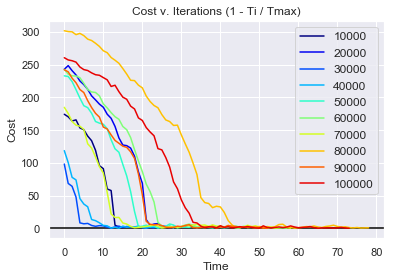

In [200]:
df_1=pd.DataFrame.from_dict(cost,orient='index').T
df_1.fillna(value=pd.np.nan, inplace=True)
#pd.concat((pd.DataFrame(df_1[col].tolist()) for col in df_1), axis=1)
df_1 = df_1.astype(float)
#df_1 = df_1[20000].apply(np.float)
df_1

plt.xlabel("Time")
plt.ylabel("Cost", fontsize=12)
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1.01, 11))))

#Add the legend
plt.axhline(y=0, color='black', linestyle='-')
plt.title("Cost v. Iterations (1 - Ti / Tmax)")

for i in df_1.columns:
    plt.plot(df_1[i])
    
    
plt.legend(fontsize=12)
plt.savefig('case_1.png')

# For Case ti * g
Now try from 0 to 100,000 in steps of 10,000 with different probabilities for geometrically scaling the temperature. Create a dataframe for more analysis ater on

In [33]:
df_case2 = pd.DataFrame(columns=['iterations','threshold','init_x','init_y','final_x','final_y','cost'])

cost_2 = dict()

for i in range(0,100001,10000):
    cost_2[i] = list()
    if i != 0:
        for j in range(0, 11, 1):
            a = Annealer(i, j/10, 0)
            obj, states, costs = a.anneal()
            #average.append(np.average(costs))
            print([i,j/10,a.states["x"][0],a.states["y"][0], states[-1][0][0], states[-1][1][0], float(costs[-1])])
            df_case2 = df_case2.append({"iterations":i,"threshold":j/10, "init_x":a.states["x"][0], "init_y":a.states["y"][0], \
                       "final_x":states[-1][0][0], "final_y":states[-1][1][0], "cost":float(costs[-1])}, ignore_index=True)
            cost_2[i].append({"threshold":j/10,"costs":costs})
df_case2.head()


/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide


[10000, 0.0, 2.9547190907469876, -5, 1.224670894586811, 0.014985709735035447, 0.4654925927881539]


/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: overflow encountered in exp


[10000, 0.1, 8.859208730305404, -7, 5.164645636135304, 0.2667150080471197, 0.6059307439466375]
[10000, 0.2, 2.7049634479132827, -10, -3.2049314070965185, 0.10275045104828831, 0.6561496858569648]
[10000, 0.3, 9.409057985418144, -10, -0.19542534939147288, 0.00038210397164601165, 0.14201161943260984]
[10000, 0.4, 5.891549096651403, -4, 4.208632727630426, 0.17703128554548936, 1.1147569566766153]
[10000, 0.5, -9.790454696834438, 1, -8.705966977751562, 0.7583349265902972, 2.003710063995129]
[10000, 0.6, -7.006400142754357, -10, -11.248295848552806, 1.265276509009003, 0.6033640235083403]
[10000, 0.7, 2.294765783134064, 7, -1.9130949688945256, 0.036785666345406406, 1.4459432069448652]
[10000, 0.8, 8.316684104193762, -4, 5.179345989645877, 0.2682790263142593, 0.6290513529796161]
[10000, 0.9, -4.0660077382180155, -1, -3.970957184072133, 0.15735671097401088, 1.8721916487834775]
[10000, 1.0, 4.1691444660611765, -4, 2.2862094110723405, 0.05225511611036097, 0.475262468633945]
[20000, 0.0, -9.4942727

,iterations,threshold,init_x,init_y,final_x,final_y,cost
0,"10,000.0",0.0,3.0,-5.0,1.2,0.0,0.5
1,"10,000.0",0.1,8.9,-7.0,5.2,0.3,0.6
2,"10,000.0",0.2,2.7,-10.0,-3.2,0.1,0.7
3,"10,000.0",0.3,9.4,-10.0,-0.2,0.0,0.1
4,"10,000.0",0.4,5.9,-4.0,4.2,0.2,1.1


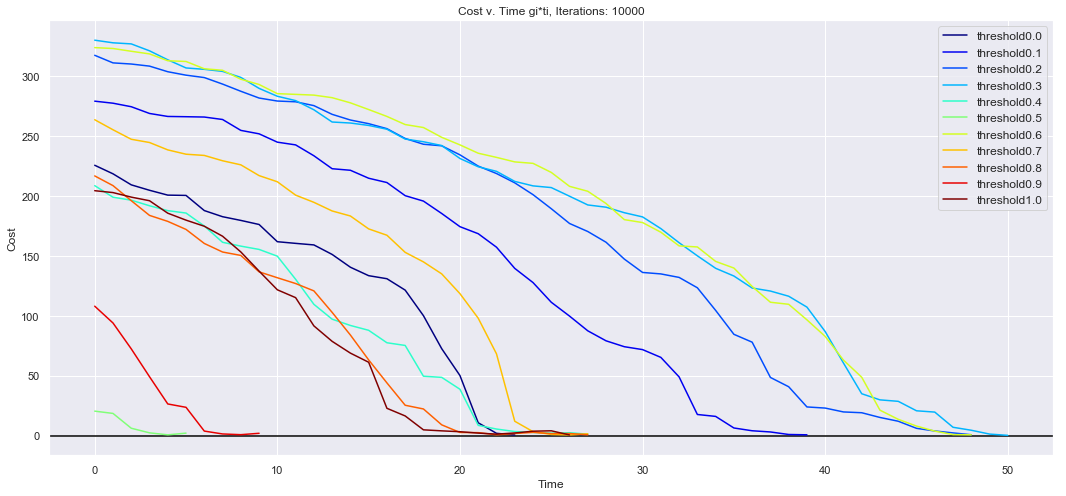

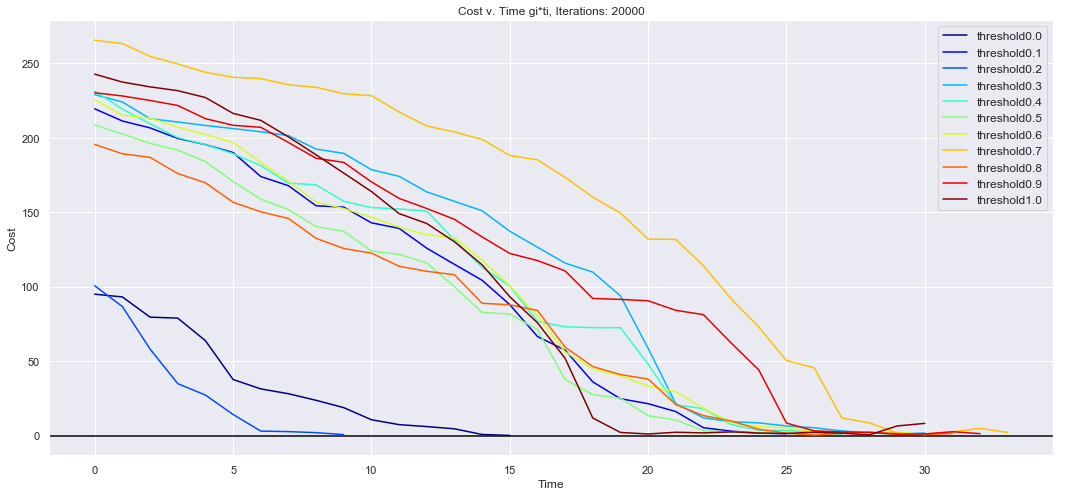

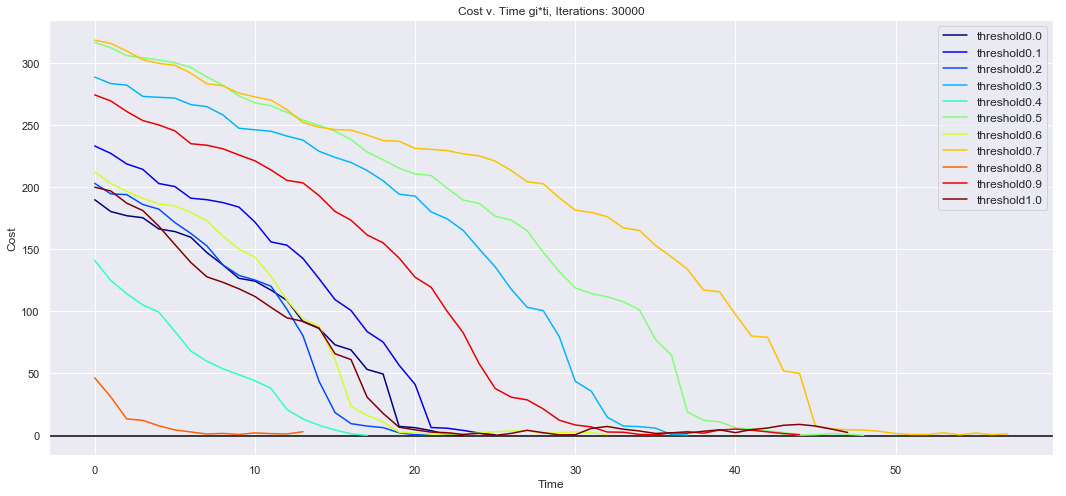

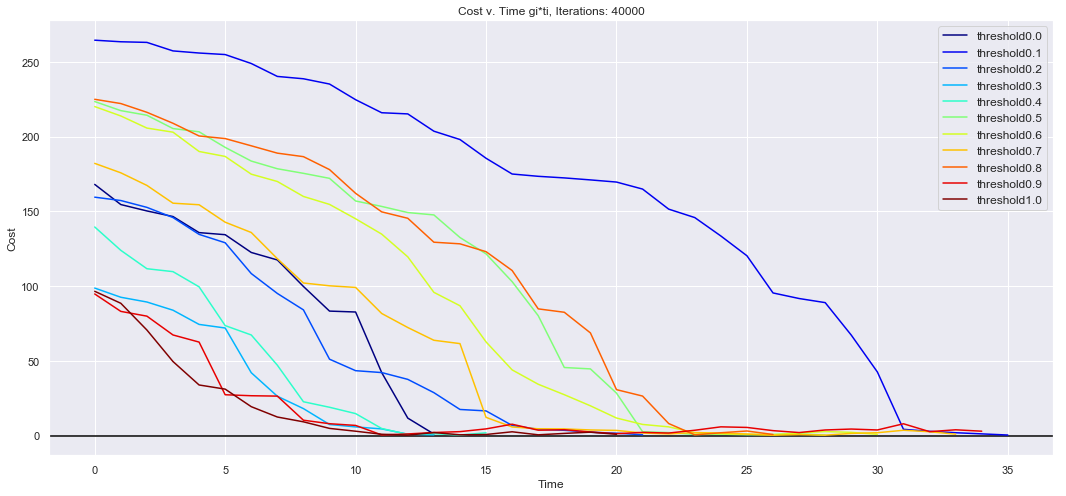

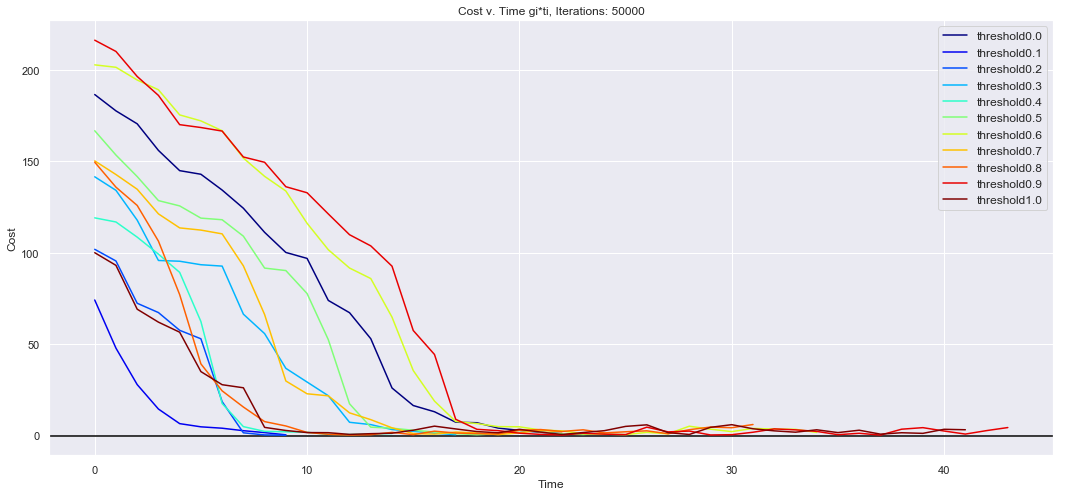

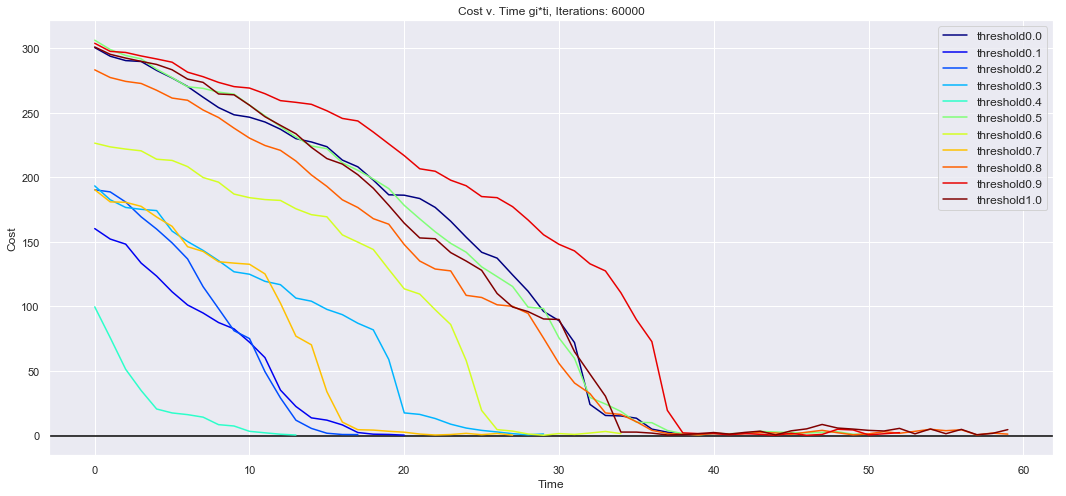

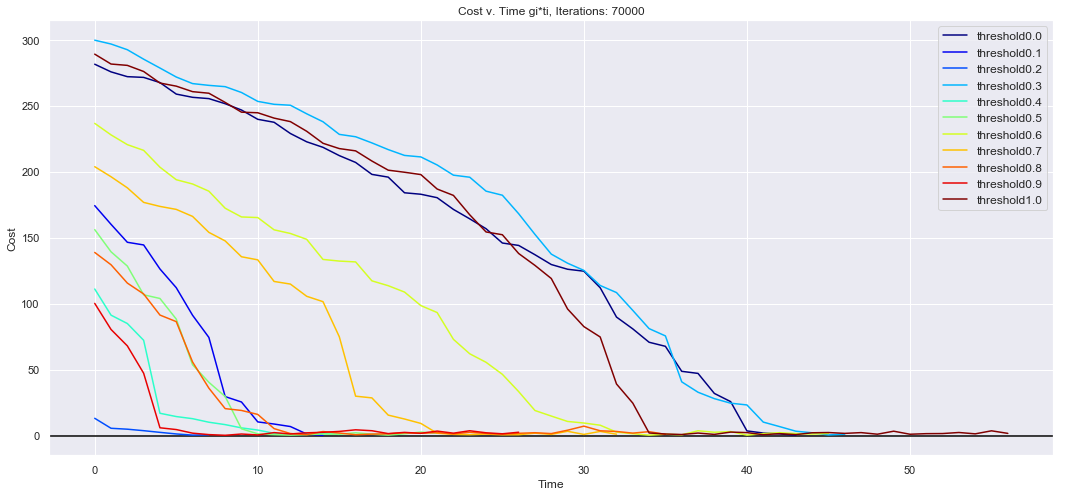

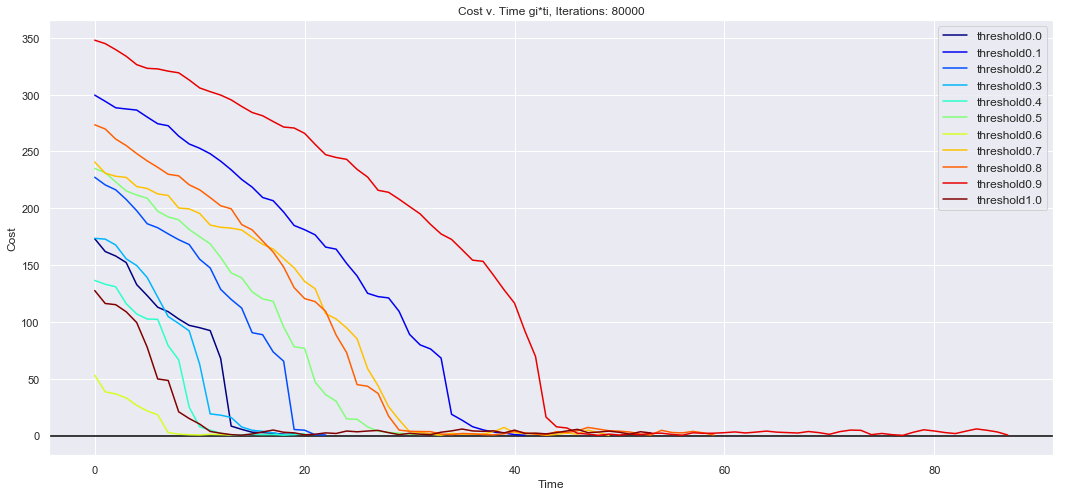

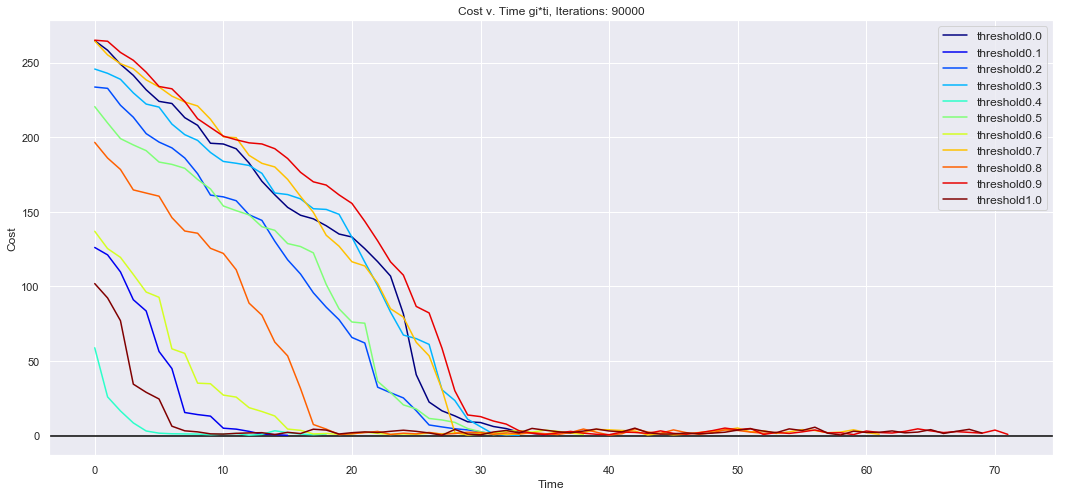

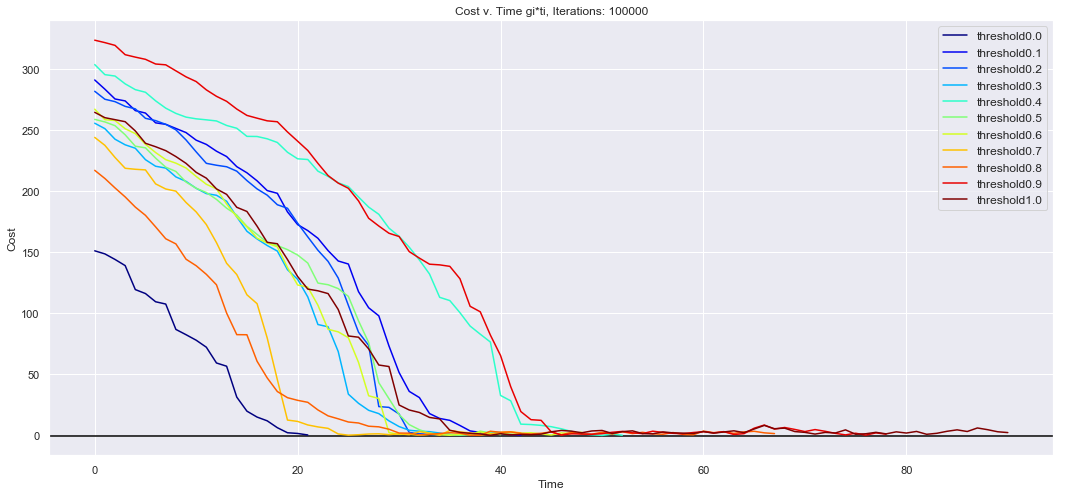

In [199]:
df_2=pd.DataFrame.from_dict(cost_2,orient='index').T.drop(columns=[0])

''' for every iteration, we want to plot the probability'''
# Set the title of the subplot
#plt.set_title("Average costs per Iteration", fontsize=16)

for i in list(df_2.columns):
    fig = plt.figure(figsize=(18, 8))
    ax1 = fig.add_subplot(111)
    colormap = plt.cm.gist_ncar
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1.01, 11))))

    plt.xlabel("Time")
    plt.ylabel("Cost", fontsize=12)
    #Add the legend
    plt.axhline(y=0, color='black', linestyle='-')
    plt.title("Cost v. Time gi*ti, Iterations: {}".format(i))
    for j in range(len(df_2[i])):
        df_2_1 = df_2[i].apply(pd.Series).rename(columns={0:'threshold',1:'costs'}) # different indexes represent different iterations
        df_2_2 = pd.DataFrame(df_2_1['costs'][j]).rename(columns={0:"threshold{}".format(df_2_1['threshold'][j])}) # different indexes represent different thresholds
        df_2_2 = df_2_2.astype(float)
        for k in df_2_2.columns:
            plt.plot(df_2_2[k])
    plt.legend(fontsize=12)
    plt.savefig('case_2_{}.png'.format(i))
#df_2_1
#df_2_final

# For case (1-ti/tmax) * g
Now try from 0 to 100,000 in steps of 10,000 with different probabilities for geometrically scaling the temperature. Create a dataframe for more analysis ater on

In [30]:
df_case3 = pd.DataFrame(columns=['iterations','threshold','init_x','init_y','final_x','final_y','cost'])

cost_3 = dict()

for i in range(0,100001,10000):
    cost_3[i] = list()
    if i != 0:
        for j in range(0, 11, 1):
            a = Annealer(i, j/10, 1)
            obj, states, costs = a.anneal()
            #average.append(np.average(costs))
            print([i,j/10,a.states["x"][0],a.states["y"][0], states[-1][0][0], states[-1][1][0], float(costs[-1])])
            df_case3 = df_case3.append({"iterations":i,"threshold":j/10, "init_x":a.states["x"][0], "init_y":a.states["y"][0], \
                       "final_x":states[-1][0][0], "final_y":states[-1][1][0], "cost":float(costs[-1])}, ignore_index=True)
            cost_3[i].append({"threshold":j/10,"costs":costs})
            
df_case3.head()


/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in true_divide


[10000, 0.0, 4.203562398438823, 0, 3.5207068479945427, 0.12389769877503914, 0.8839948896785548]
[10000, 0.1, 6.1164620460615815, 3, 5.2045965603186595, 0.2708518978924772, 0.6654236465653858]
[10000, 0.2, -1.8641364653674426, 3, -4.814086767051642, 0.2317582204287497, 0.2495058305657358]
[10000, 0.3, 0.05355570477333593, 9, -5.612531438675338, 0.31495189939307605, 0.7732038850465893]
[10000, 0.4, 9.860232393862233, -1, 7.170240842779925, 0.5142095675630252, 1.0992266848299148]
[10000, 0.5, 4.542337417856199, 0, 4.395378984203139, 0.19321812222006501, 0.6395148084744264]
[10000, 0.6, 0.39540519006507324, -8, -3.2171034184832528, 0.10344358219203081, 0.8024163339035096]
[10000, 0.7, -5.998766149350999, 0, -7.8096355225339575, 0.609926184594684, 0.49216576786697314]
[10000, 0.8, 4.174675476839667, -9, -2.025465551456762, 0.04105275266416998, 0.6055367745176395]
[10000, 0.9, 2.847609961141554, 7, -2.5053392199451276, 0.06286001020991344, 1.0380880302346052]
[10000, 1.0, 2.0880923323538028,

/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: overflow encountered in exp


[30000, 0.2, 4.412667172021202, 5, 2.3386347613679987, 0.05471590629046457, 0.6110421655530115]
[30000, 0.3, -10.448487978838978, 7, -14.72665033622975, 2.168739526263945, 0.213849570125574]
[30000, 0.4, 7.9684644128412785, -1, 7.118851973700819, 0.5068277469375373, 0.8583035239165889]
[30000, 0.5, 2.1907624837563517, 2, -0.430223379727972, 0.0018204329128543653, 0.6478630656486589]
[30000, 0.6, 9.82599352593099, 2, 9.474300708996763, 0.8976402683259885, 0.6013027323799544]
[30000, 0.7, -7.390192838512848, 5, -12.66583921680773, 1.6042516782462377, 0.4371165019845184]
[30000, 0.8, -8.317626829788658, 9, -14.537913461331106, 2.113464865246281, 0.711808765114818]
[30000, 0.9, -13.69528620737983, -2, -14.345442881707273, 2.057913964187045, 0.22649912865316885]
[30000, 1.0, 9.874671222462066, -1, 5.261090547576575, 0.2768179523803592, 0.6742897565268907]
[40000, 0.0, -5.65859914641516, -7, -9.57324346696446, 0.9164554918959888, 0.3839105790718533]
[40000, 0.1, -9.759053629253895, -8, -9.19

,iterations,threshold,init_x,init_y,final_x,final_y,cost
0,"10,000.0",0.0,4.2,0.0,3.5,0.1,0.9
1,"10,000.0",0.1,6.1,3.0,5.2,0.3,0.7
2,"10,000.0",0.2,-1.9,3.0,-4.8,0.2,0.2
3,"10,000.0",0.3,0.1,9.0,-5.6,0.3,0.8
4,"10,000.0",0.4,9.9,-1.0,7.2,0.5,1.1


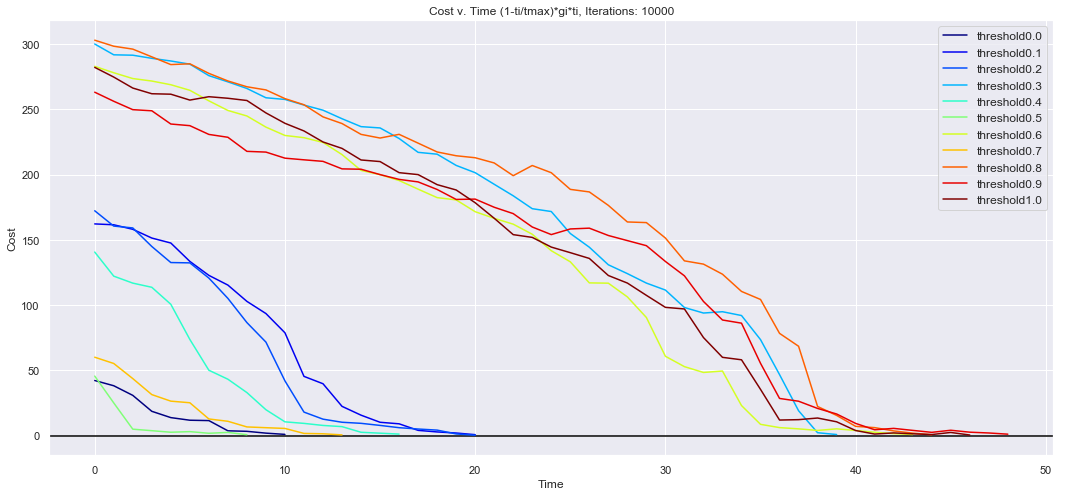

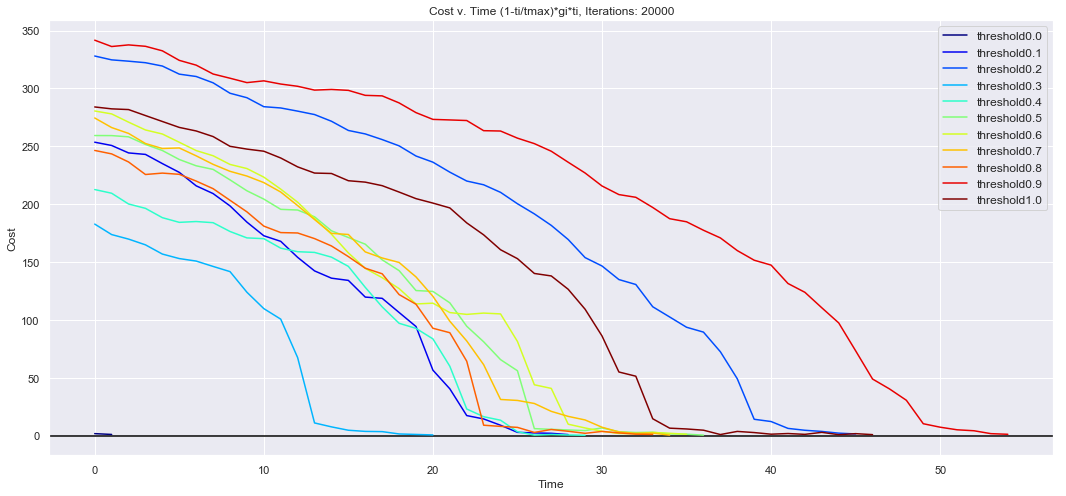

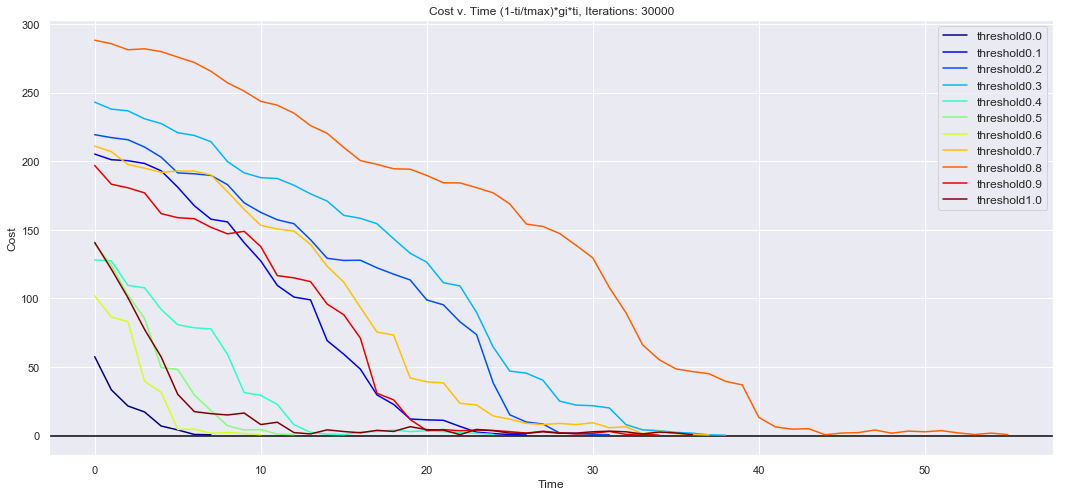

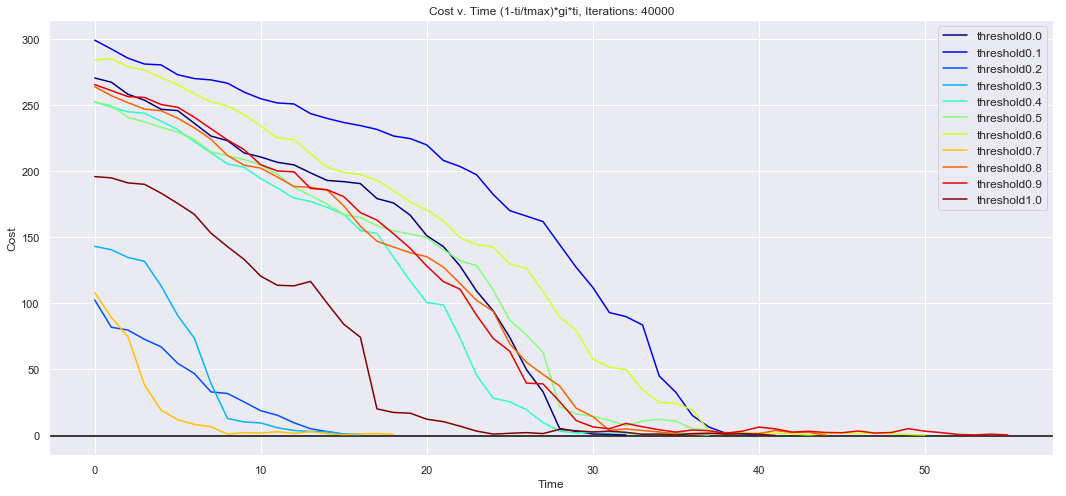

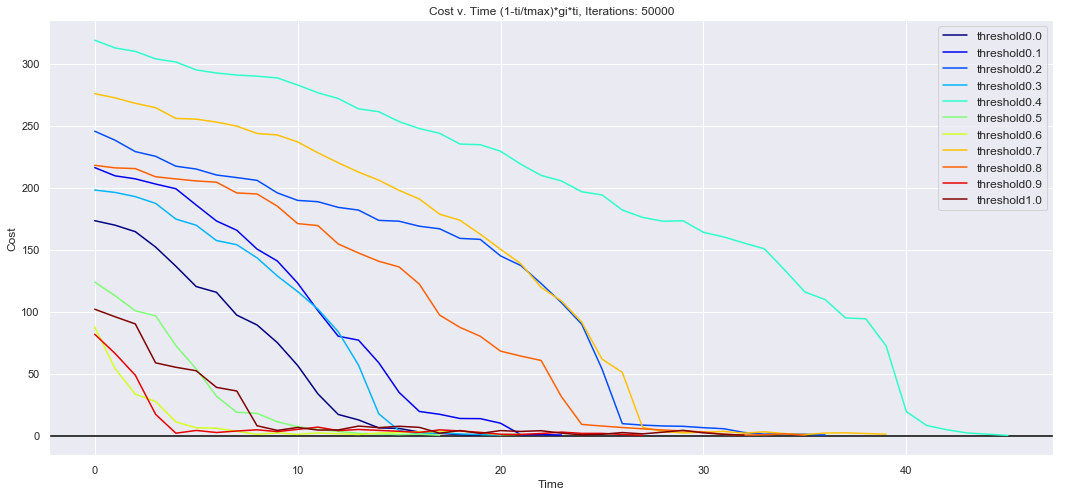

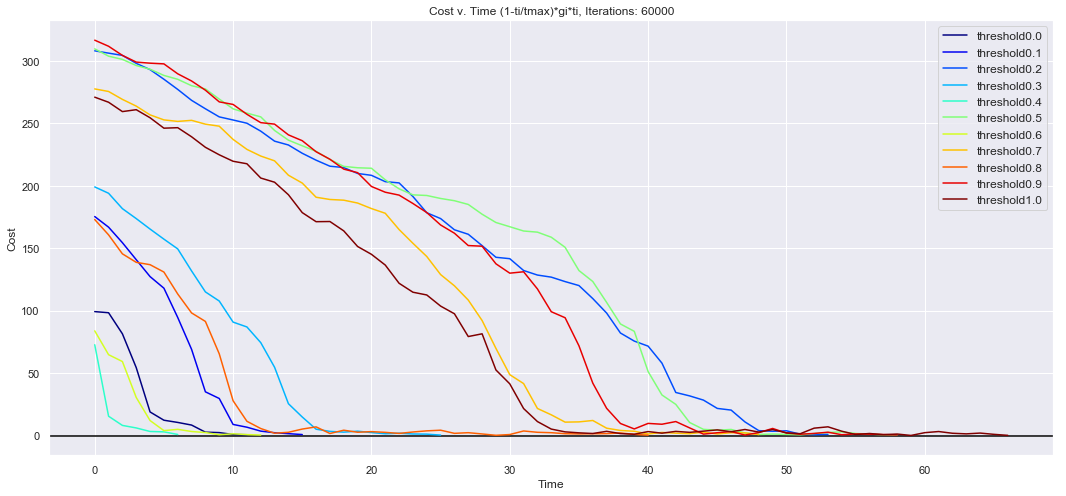

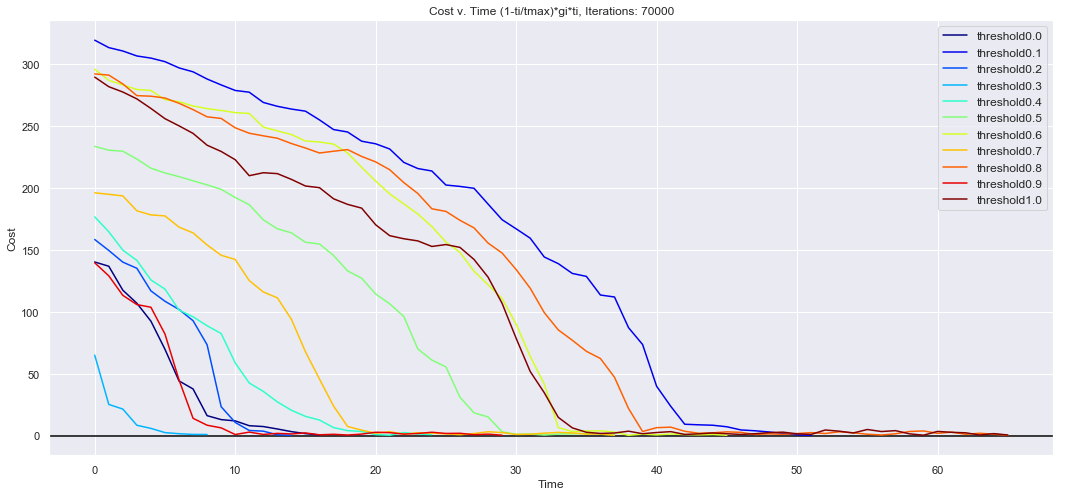

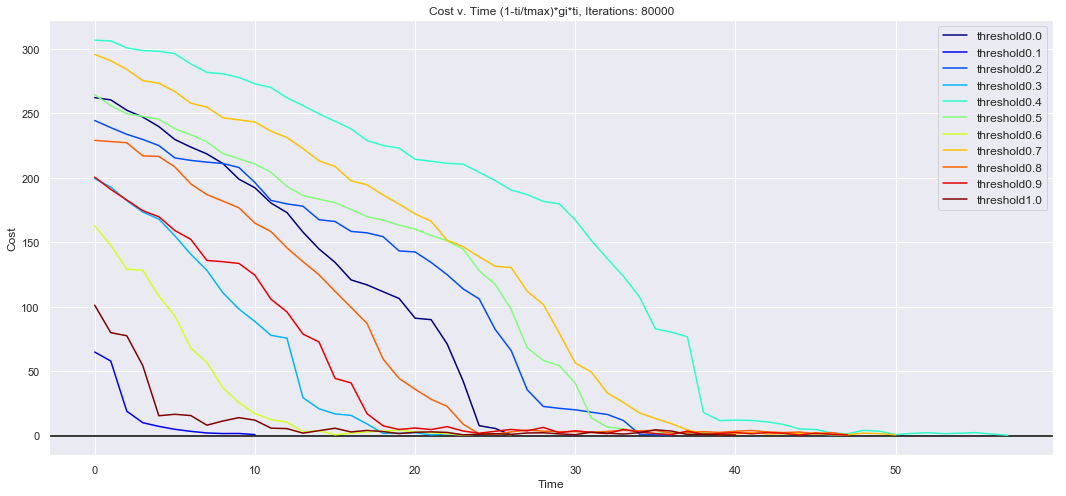

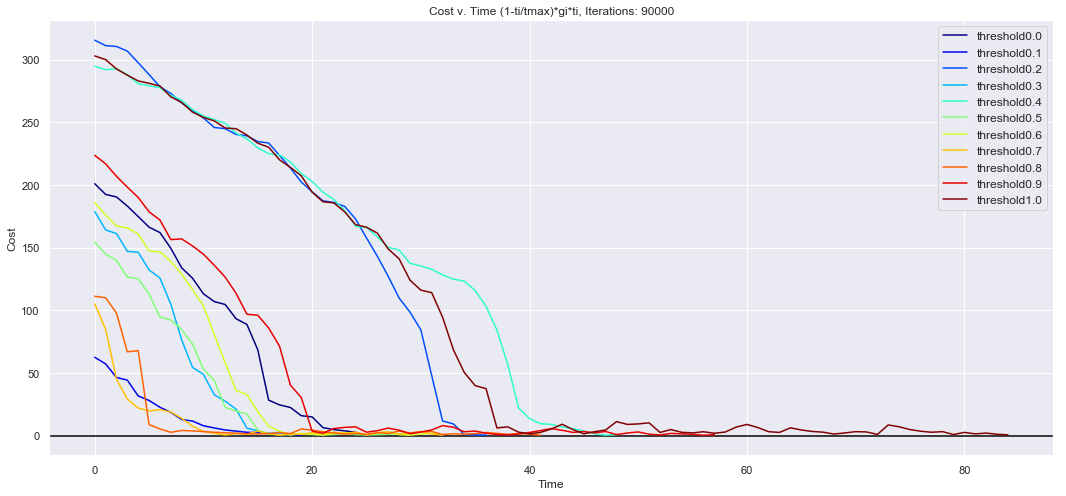

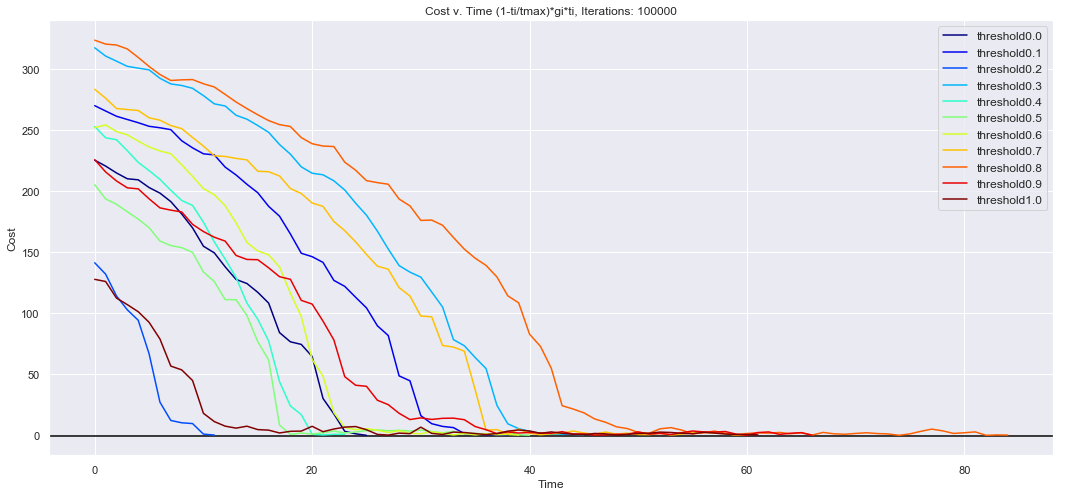

In [198]:
df_3=pd.DataFrame.from_dict(cost_3,orient='index').T.drop(columns=[0])

''' for every iteration, we want to plot the probability'''
# Set the title of the subplot
#plt.set_title("Average costs per Iteration", fontsize=16)
for i in list(df_3.columns):
    fig = plt.figure(figsize=(18, 8))
    ax1 = fig.add_subplot(111)
    colormap = plt.cm.gist_ncar
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1.01, 11))))

    plt.xlabel("Time")
    plt.ylabel("Cost", fontsize=12)
    #Add the legend
    plt.axhline(y=0, color='black', linestyle='-')
    plt.title("Cost v. Time (1-ti/tmax)*gi*ti, Iterations: {}".format(i))
    for j in range(len(df_3[i])):
        df_3_1 = df_3[i].apply(pd.Series).rename(columns={0:'threshold',1:'costs'}) # different indexes represent different iterations
        df_3_2 = pd.DataFrame(df_3_1['costs'][j]).rename(columns={0:"threshold{}".format(df_3_1['threshold'][j])}) # different indexes represent different thresholds
        df_3_2 = df_3_2.astype(float)
        for k in df_3_2.columns:
            plt.plot(df_3_2[k])
    plt.legend(fontsize=12)
    plt.savefig('case_3_{}.png'.format(i))
#df_2_1
#df_2_final

Groupby in a dataframe to easily plot 

In [12]:
df.groupby(['threshold']).mean().reset_index()


,threshold,iterations,init_x,init_y,final_x,final_y,cost
0,0.0,"55,000.0",-2.6,2.5,-4.9,0.7,0.4
1,0.1,"55,000.0",-4.8,0.0,-7.2,0.8,0.6
2,0.2,"55,000.0",1.5,2.0,-1.0,0.4,0.6
3,0.3,"55,000.0",-3.4,1.5,-6.2,0.8,0.4
4,0.4,"55,000.0",-1.6,0.3,-4.3,0.5,0.6
5,0.5,"55,000.0",-3.0,1.1,-5.0,0.8,0.6
6,0.6,"55,000.0",-4.1,-0.6,-6.5,1.0,0.7
7,0.7,"55,000.0",-3.6,-2.8,-6.8,0.9,0.6
8,0.8,"55,000.0",-4.6,-1.8,-8.6,1.0,0.4
9,0.9,"55,000.0",-2.1,-2.8,-8.3,0.9,0.7


Calculate the average costs for each number of runs

/Users/tinkertanker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


<Figure size 1152x432 with 0 Axes>

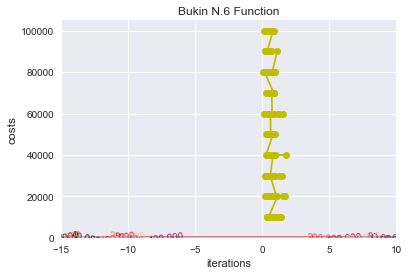

In [241]:
fig = plt.figure(figsize=DIMS)
x1m, x2m = np.meshgrid(i1, i2)
fm = np.zeros(x1m.shape)
for i in range(x1m.shape[0]):
    for j in range(x1m.shape[1]):
        fm[i][j] = 100 * np.sqrt(abs(x2m[i][j]) - 0.01*(x1m[i][j]**2)) + 0.01 * abs(x1m[i][j] + 10)
                
        # Create a contour plot
plt.figure()
        # Specify contour lines
        #lines = range(2,52,2)
        # Plot contours
CS = plt.contour(x1m, x2m, fm)#,lines)
        # Label contours
plt.clabel(CS, inline=1, fontsize=10)
        # Add some text to the plot
plt.title('Bukin N.6 Function')
#plt.xlabel('x1')
#plt.ylabel('x2')


#ax1 = fig.add_subplot(111)
# Set the title of the subplot
#plt.set_title("Average costs per Iteration", fontsize=16)
# Plot from the df
plt.plot(df["cost"], df["iterations"],'y-o')
#df.plot(x='iterations', y='cost', ax=ax1, marker="o", 'y-o')
#df.plot(x='iterations', y='threshold', ax=ax1, marker='o', 'y-o')
# Configure the ticks and labels of the x-axis...
plt.xlabel("costs")
plt.ylabel("iterations", fontsize=12)
#Add the legend
ax1.legend(fontsize=12)

